# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
# Needed packages for this example
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Start out spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [3]:
# We have an example file (sparkify_log_small.json)
path = "sparkify_log_small.json"
user_log = spark.read.json(path)

# Data Exploration 

The next cells explore the data set.

In [6]:
# Check the first 5 row of records from the json file
user_log.take(5)

[Row(artist=u'Showaddywaddy', auth=u'Logged In', firstName=u'Kenneth', gender=u'M', itemInSession=112, lastName=u'Matthews', length=232.93342, level=u'paid', location=u'Charlotte-Concord-Gastonia, NC-SC', method=u'PUT', page=u'NextSong', registration=1509380319284, sessionId=5132, song=u'Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent=u'"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId=u'1046'),
 Row(artist=u'Lily Allen', auth=u'Logged In', firstName=u'Elizabeth', gender=u'F', itemInSession=7, lastName=u'Chase', length=195.23873, level=u'free', location=u'Shreveport-Bossier City, LA', method=u'PUT', page=u'NextSong', registration=1512718541284, sessionId=5027, song=u'Cheryl Tweedy', status=200, ts=1513720878284, userAgent=u'"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId=u'1000'),
 Row(artist=u'Cobra Starship Featuring Leighton Meester', 

In [7]:
# It is very hard to read above rows. In this way, we can easily see what columns we have on these rows
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Actual statistics from the json file
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [12]:
# Some default information about json file based on the artist columns
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [ ]:
# Some default information about json file based on the "sessionId" columns
user_log.describe("sessionId").show()

In [13]:
# Count how many records we have in this json file
user_log.count()

10000

In [14]:
# Get all the values from the page columns, remove dublicates and sort all values by name
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [15]:
# Take "userId", "firstname", "page" and "song" infomation that belongs to user who has user id "1046"
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Christmas Tears Will Fall'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Be Wary Of A Woman'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Public Enemy No.1'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Reign Of The Tyrants'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Father And Son'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'No. 5'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Seventeen'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'Home', song=None),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'War on war'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Killermont Street'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'NextSong', song=u'Black & Blue'),
 Row(userId=u'1046', firstname=u'Kenneth', page=u'Logout', song=

# Calculating Statistics by Hour

In [16]:
# we defined the get_hour function to apply later
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [17]:
# We added another column called "hour" to the data with the hour information extacted through "get_hour" function specified above.
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [20]:
# We saw that the function is applied on the first row of the json file
user_log.head()

Row(artist=u'Showaddywaddy', auth=u'Logged In', firstName=u'Kenneth', gender=u'M', itemInSession=112, lastName=u'Matthews', length=232.93342, level=u'paid', location=u'Charlotte-Concord-Gastonia, NC-SC', method=u'PUT', page=u'NextSong', registration=1509380319284, sessionId=5132, song=u'Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent=u'"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId=u'1046', hour=u'23')

In [21]:
# Collect how many songs are played via "NextSong" option in different hours
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [22]:
# Show the results of the previous line
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  456|
|   2|  454|
|   3|  382|
|   4|  302|
|   5|  352|
|   6|  276|
|   7|  348|
|   8|  358|
|   9|  375|
|  10|  249|
|  11|  216|
|  12|  228|
|  13|  251|
|  14|  339|
|  15|  462|
|  16|  479|
|  17|  484|
|  18|  430|
|  19|  362|
+----+-----+
only showing top 20 rows



In [25]:
# Convert this table to pandas
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

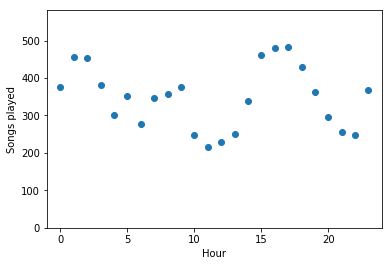

In [26]:
# Plotting
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [27]:
# Checj if there is any record with no userID and sessionID
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [28]:
# Checks count to make sure there is no such record
user_log_valid.count()

10000

In [29]:
# Sort the records based on the userID and remove the dublicates
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [33]:
# Filter all the records which has "" value in its userId column
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [31]:
# APparently, we found 336 records which have "" userId column
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [32]:
# Check who downgraded their service
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  12|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [34]:
# We found the user which has userID of "1138" downgraded her service. So lets take the log belongs to her including "userId", "firstname", "page", "level" and "song"
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId=u'1138', firstname=u'Kelly', page=u'Home', level=u'paid', song=None),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Everybody Everybody'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Gears'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Use Somebody'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Love Of My Life (1993 Digital Remaster)'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Down In The Valley Woe'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Treat Her Like A Lady'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u"Everybody Thinks You're An Angel"),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', song=u'Fourteen Wives'),
 Row(userId=u'1138', firstname=u'Kelly', page=u'NextSong', level=u'paid', 

In [35]:
# Create a function to detect the point in which she downgraded the service
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [36]:
# add this information column to the data
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [40]:
# Shows but this always does to the first row
user_log_valid.head()

Row(artist=u'Showaddywaddy', auth=u'Logged In', firstName=u'Kenneth', gender=u'M', itemInSession=112, lastName=u'Matthews', length=232.93342, level=u'paid', location=u'Charlotte-Concord-Gastonia, NC-SC', method=u'PUT', page=u'NextSong', registration=1509380319284, sessionId=5132, song=u'Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent=u'"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId=u'1046', hour=u'23', downgraded=0)

In [39]:
from pyspark.sql import Window

In [42]:
# group the dataframe by the user Id and order it based on the descending time with unbounded range in ts
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [43]:
# Add phase column to the data based on the downgraded option and add it to all columns
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [44]:
# And between all these columns created above lets see the userId "1138"
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId=u'1138', firstname=u'Kelly', ts=1513729066284, page=u'Home', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513729066284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513729313284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513729552284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513729783284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513730001284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513730263284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513730518284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513730768284, page=u'NextSong', level=u'paid', phase=1),
 Row(userId=u'1138', firstname=u'Kelly', ts=1513731182284, page=u'NextSong', level=u'p